# DM1590 Final Project: News title analyzer

## Authors: Markus Brewitz, Saga Jonasson, Vilhelm Norström, Martin Ryberg Laude

---

### Background and motivation

News articles come in a variety of subjects and categories describing their field and relevance. Some of these have self-reported tags, but too many do not, or provide inaccurate tags. Tagging articles has the potential to help information-seekers to judge the relevance of articles and filter them by interest, especially in this day and age where information is so abundant it can be exhausting. In this project we set out to use machine learning to tag articles based on their titles, to aid the effort of searching for relevant information.

### Dataset

https://archive.ics.uci.edu/ml/datasets/News+Aggregator

This dataset contains a lot of information taken from different news articles, but for our intents and purposes, we will only be looking at two things: News titles, and their corresponding theme, or category:
* **b** for *Business*
* **t** for *Science/Tech*
* **e** for *Entertainment*
* **m** for *Health*

Our algorithms will learn exclusively from the database's news titles (no other information, such as the publisher, links, or even the articles themselves through the links will be used). The supervised algorithms will, of course, learn from each news title's category as well.

### Methodology

Describe what you are doing and how you are doing it.

---

##  Import and handle data

### 1.1 Import data and libraries

In [6]:
# Todo: remove everything we don't use later in the program
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import mglearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import svm
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

column_names = ["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"]
data = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv',sep='\t',header=None, names=column_names)

[nltk_data] Downloading package wordnet to /Users/mrl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mrl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mrl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Splits the data set into a much smaller data set

In [7]:
data_titles, temp1, data_categories, temp2 = train_test_split(data.title, data.category, train_size=0.1)
data = pd.concat([data_titles, data_categories], axis=1)

In [201]:
# ONLY run this if you want a shorter training and test set
# Useful for testing code

data = pd.read_csv('NewsAggregatorDataset/newsCorpora_shortened.csv', sep='\t', header=None, names=column_names_short)

### 1.2 Vectorize data

Since the information in our database that the algorithms are going to learn from consists of *words* (not something computers easily understand), we first need to convert this data to something more easily understood, ie *vectors*.

By making use of the Bag of Words method (BoW) and its more advanced term frequency identifier 'variant' (Eh, we'll just change the description later) we can transform our data represented in documents of strings to feature vectors that we can machine learning methods on. To further improve the vectorization of our dataset we can also make use of n-Grams, as well as advanced methods of tokenization for the words in our dataset, such as normalizing the data through lemmatization.

In [8]:
# Delete duplicates
data[data['title'].duplicated(
    keep=False)].sort_values('title').head(8)
data = data.drop_duplicates('title')
corpus = data.title

# Split the data
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, data.category, train_size=0.7)  # TODO: Figure out a good ratio for training data vs test data

# Convert y to more easily understood values
y_train = ['Business' if i=='b' else 'Science/Tech' if i=='t' else 'Entertainment' if i=='e' else 'Health' if i=='m' else i for i in y_train]
y_test = ['Business' if i=='b' else 'Science/Tech' if i=='t' else 'Entertainment' if i=='e' else 'Health' if i=='m' else i for i in y_test]

# Establishing stopwords
punc = ['.', ',', '"', "'", '?', '!', ':',
        ';', '(', ')', '[', ']', '{', '}', "%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

'''# Creates a tokenizer for stemming
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(document):
    return [stemmer.stem(word) for word in tokenizer.tokenize(document.lower())]'''


# Creates a tokenizer for lemmatization
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def lem_tokenize(document):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(document.lower())]

# TODO: Experiment with the min_df value to find what works best for it
vect = TfidfVectorizer(min_df=11, ngram_range=(1, 2), stop_words=stop_words,
                        tokenizer=lem_tokenize)


'''# Temporary code
vect_temp = TfidfVectorizer(min_df=11, ngram_range=(1, 2), stop_words=stop_words,
                        tokenizer=tokenize)
vect_temp.fit(corpus_train)
X_train_temp = vect_temp.transform(corpus_train)'''


# Transforms the training data using our vectorizer
vect.fit(corpus_train)
X_train = vect.transform(corpus_train)
X_test = vect.transform(corpus_test) # Vectorizing the test data
vec_matrix = vect.fit_transform(corpus) # Vectorizes the data

# Get feature names (title words)
feature_names = np.array(vect.get_feature_names_out())


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [ ]:
''' Temporary cell for comparing the number of features from the different tokenization methods '''

#print("vec_matrix.shape: {}".format(vec_matrix.shape))

vect3 = TfidfVectorizer(min_df=11, ngram_range=(1, 2), stop_words=stop_words)
vect3.fit(corpus_train)
X_train3 = vect3.transform(corpus_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_temp.shape: {}".format(X_train_temp.shape))
print("X_train3.shape: {}".format(X_train3.shape))

print("Vocabulary size: {}".format(len(vect3.vocabulary_)))

'''print("Vocabulary lemm: {}".format(vect.vocabulary_))
print("Vocabulary stem: {}".format(vect_temp.vocabulary_))'''


### 1.3 Temporary cells

Experimental cells for min_df parameter and logistic regression

In [6]:
'''*** This cell is only here to visualize the min_df param. It has no real meaning outside of that scope ***'''
# Find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

print()

max_value_temp = X_train_temp.max(axis=0).toarray().ravel()
sorted_by_tfidf_temp = max_value_temp.argsort()

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf_temp[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf_temp[-20:]]))


'''max_value3 = X_train3.max(axis=0).toarray().ravel()
sorted_by_tfidf3 = max_value3.argsort()

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf3[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf3[-20:]]))'''


Features with lowest tfidf:
['chemical' 'hit' 'drift' 'keith' 'population' 'jean' 'internet explorer'
 'fcc chairman' "'harry potter'" 'mickey rooney' 'paula' 'drew barrymore'
 'radio' 'rail' 'christina' 'port' 'affirms' 'meryl' 'ftc'
 'chikungunya virus']
Features with highest tfidf: 
['nsa' 'diane sawyer' 'drew' 'dragon' 'dr oz' 'dr' 'downey' 'dow jones'
 'dollar steady' 'detailed' "night's" 'dna' 'niro' 'divorce' 'nj'
 'nokia x' 'directed' 'dip' 'documentary' 'gear']

Features with lowest tfidf:
['night' 'carrier' 'dioxide' 'hand' 'oecd' 'hq' 'fitch' 'f bomb'
 'experience' 'polio free' 'potato' 'pot' 'pay billion' 'central'
 'gwen stefani' 'cast member' 'cosmos' 'fomc' 'fitness' 'mail']
Features with highest tfidf: 
['bb' 'global' 'music service' 'deadly ebola' 'beach' 'musician' "man's"
 'geopolitical' "day's" 'glory' 'george clooney' 'germany' 'performs'
 'gigafactory' 'gilead' 'archie' "girl' trailer" 'megan' 'banana'
 'ordered']


'max_value3 = X_train3.max(axis=0).toarray().ravel()\nsorted_by_tfidf3 = max_value3.argsort()\n\nprint("Features with lowest tfidf:\n{}".format(\n    feature_names[sorted_by_tfidf3[:20]]))\n\nprint("Features with highest tfidf: \n{}".format(\n    feature_names[sorted_by_tfidf3[-20:]]))'

In [12]:
''' ***DO NOT RUN THIS CELLBLOCK IF YOU CAN AVOID IT*** '''

# Searches for the best value for C for logistic regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 1}


In [13]:
'''
Best cross-validation score: 0.89
Best parameters:  {'C': 1}
'''
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.99


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: 

Best cross-validation score: 0.88
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


"\nBest cross-validation score: 0.88\nBest parameters:\n{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}\n(Bigram and trigram had the same results)\n"

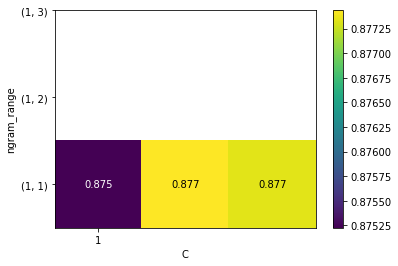

In [17]:
''' *** Cellblock for determining the best nGram value *** '''

pipe = make_pipeline(TfidfVectorizer(min_df=11, stop_words=stop_words, tokenizer=lem_tokenize), LogisticRegression(max_iter=1000))
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [1],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(corpus_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 1).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

'''
Best cross-validation score: 0.88
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
(Bigram and trigram had the same results)
'''

---
## Clustering

### The elbow method

By using the elbow method we can identify how many clusters we should pick. We look at variance percentage as a function of the amount of clusters, as we should pick a cluster amount where adding more clusters wouldn't give better modeling. Plotting a graph of this results in the marginal gain dropping at some point(s) giving a downwards angle in the graph. 

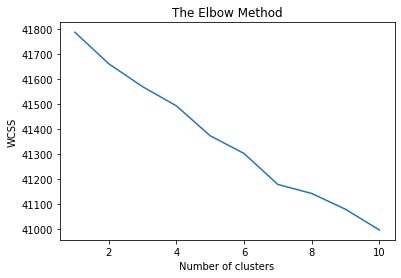

In [5]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(vec_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### 5 Clusters

Judging by the elbow graph, a reasonable cluster pick seems to be five. By utilizing the KMeans algorithm we can then fit the vectorized matrix and extract the clusters, together with the top features for each cluster. 

In [10]:
kmeans = KMeans(n_clusters=5, n_init=20)
fitted = kmeans.fit(vec_matrix)

# Extracts the top 25 features of each cluster and prints accordingly
common_words = kmeans.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' +
          ', '.join(feature_names[word_coord] for word_coord in centroid))

0 : google, say, apple, video, year, review, report, day, microsoft, million, facebook, price, star, stock, watch, season, deal, movie, game, time, billion, sale, update, 'the, market
1 : galaxy, samsung, s, samsung galaxy, galaxy s, tab, galaxy tab, note, galaxy note, v, tab s, spec, price, s mini, mini, feature, android, s v, fingerprint, v samsung, iphone, release, india, r, comparison
2 : u, kim, kardashian, kim kardashian, kanye, u s, kanye west, west, s, stock, u stock, wedding, kardashian kanye, sale, data, rise, report, rate, kim kardashian's, kardashian's, gain, market, china, say, fall
3 : new, new york, york, album, trailer, new album, video, feature, apple, ceo, home, release, google, season, new home, movie, new study, app, report, say, new trailer, u, launch new, film, study
4 : court, internet, fight, supreme, supreme court, internet explorer, explorer, aereo, google, u, fcc, court order, rule, ruling, order, appeal, security, tv, court rule, case, epa, apple, court ruli

### Visualizing
The result above is quite clear and indicates the clustering works reasonably well. An additional measure we could take is to visualize the whole vectorized matrix in a 2D plot as well, which could give additional confirmation that the algorithm correctly clusters the data. Since the data is high-dimensioned, some dimensionality reduction is required. For this we opted for principal component analysis, using a relevant module from sklearn. 

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


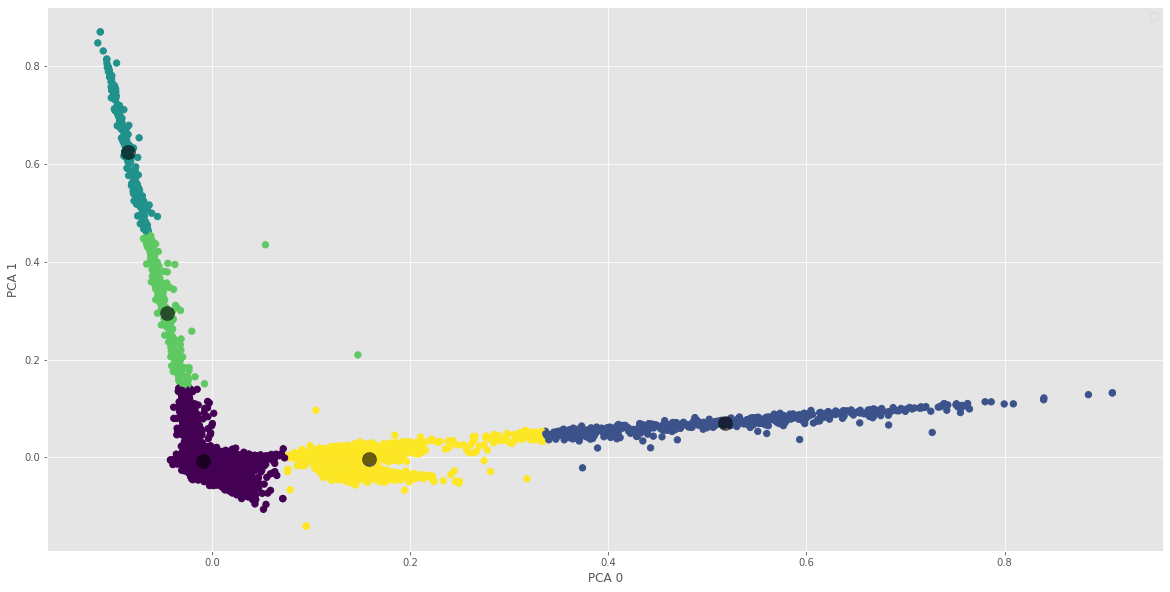

In [11]:

# Apply PCA transformation on the vectorized matrix
pca = PCA(n_components=2)
Y_sklearn = pca.fit_transform(vec_matrix.todense())

fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# Plot the transformed data and color code by cluster prediction
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],
            c=prediction, s=40, cmap='viridis', linewidths=1)

# Plot the cluster centers for visual guidance
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6)
ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

---
## Classification


### k-NN model

The k-nearest neighbor algorithm (k-NN) is a supervised machine learning algorithm mainly used for classification. It functions by comparing the euclidean distance of the new datapoint to its nearest neighbors in the training dataset, then assigning it the answer of its closest neighbors.

#### Find the most accurate k-value

In order to run, k-NN needs to know how many of its closest neighbors it should look at in order to make a decision. This is called the *k-value*, and how large it is can vastly effect the accuracy of the algorithm. The easiest way to find it is to simply test a few k-values and see which one gets the best results on the dataset you are using. This means we need to run the model several times in order to find the most accurate value of k.

This can take a long amount of time.

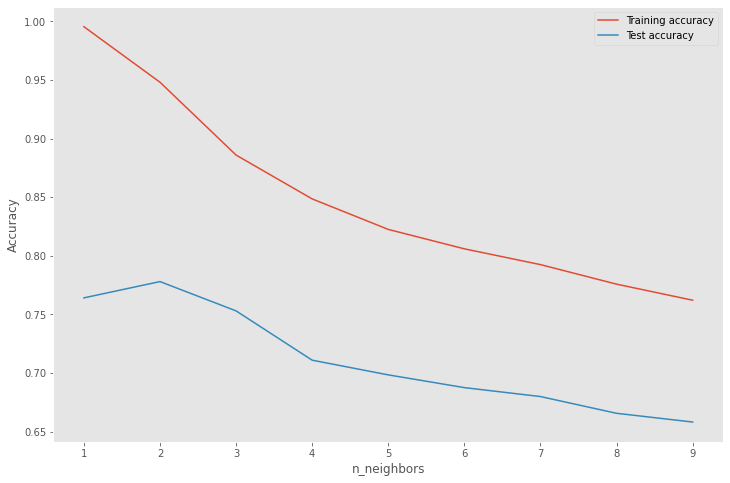

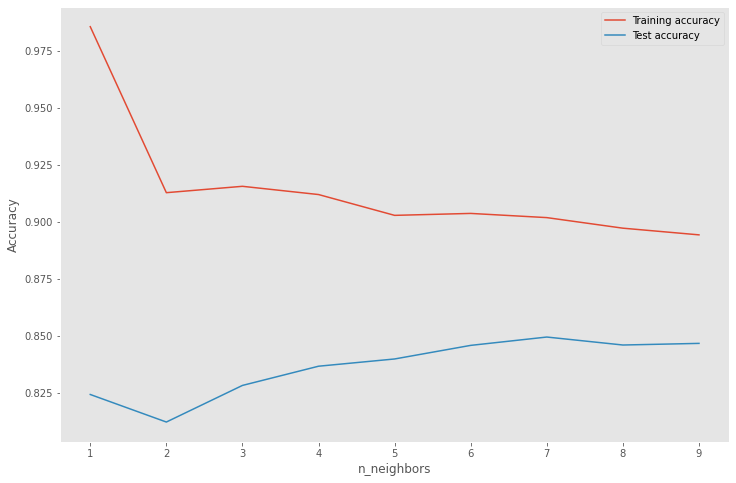

In [47]:
# Implements feature selection using SelectFromModel, together with a linear support vector classifier
select = SelectFromModel(
    LinearSVC(C=1, penalty='l1', dual=False), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
X_test_l1 = select.transform(X_test)

def find_K_value(training_data, test_data):
  # Find the most accurate k-value 
  training_accuracy = []
  test_accuracy = []
  k_arr = range(1, 10)

  # Creates and trains all of the classifiers, and saves the results in arrays
  for k in k_arr:
    clf = KNeighborsClassifier(n_neighbors=k)  # Initializes kNN classifier with k neighbors
    clf.fit(training_data, y_train) # Fits the classifier to the data
    training_accuracy.append(clf.score(training_data, y_train)) # Records training set accuracy
    test_accuracy.append(clf.score(test_data, y_test))  # Records generalization accuracy

  plt.figure(figsize=(12, 8))
  plt.plot(k_arr, training_accuracy, label="Training accuracy")
  plt.plot(k_arr, test_accuracy, label="Test accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("n_neighbors")
  plt.legend()
  plt.grid()
  plt.show()


find_K_value(X_train, X_test)
find_K_value(X_train_l1, X_test_l1)

We can see that the most accurate k-value *without* feature selection is 3, while *with* feature selection its around 7
#### Apply most accurate model

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


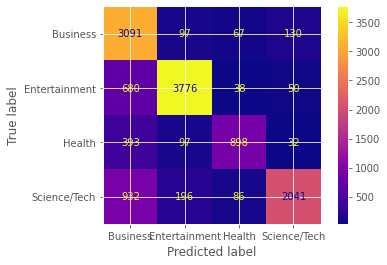

Accuracy: 0.778


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


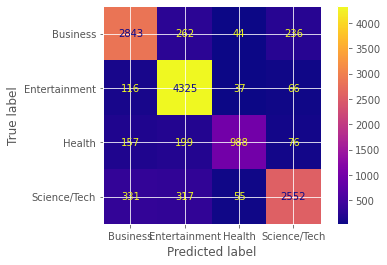

Accuracy: 0.8496


In [48]:
# KNN-method without feature selection
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap="plasma")  
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test, y_test), 4)))


#KNN-method with feature selection
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train_l1, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test_l1)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test_l1, y_test, cmap="plasma")  
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test_l1, y_test), 4)))



### Naive Bayes

Insert description here plox

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


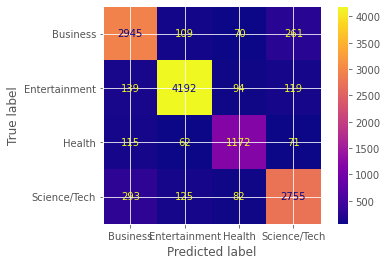

Accuracy: 0.8778


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


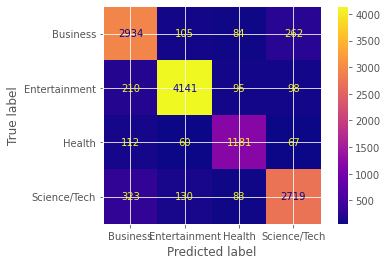

Accuracy: 0.8708


In [52]:
from sklearn.naive_bayes import ComplementNB

# Naive bayes method without feature selection
cnb = ComplementNB()

# convert to dense numpy arrays
X_train_dns = X_train.toarray()
X_test_dns = X_test.toarray()

cnb.fit(X_train_dns, y_train)

predictions = cnb.predict(X_test_dns)

# Plot confusion matrix
plot_confusion_matrix(cnb, X_test_dns, y_test, cmap="plasma")  
plt.show()

# Print accuracy
print("Accuracy: " + str(round(cnb.score(X_test_dns, y_test), 4)))


# Naive bayes method with feature selection
cnb_fs = ComplementNB()

# convert to dense numpy arrays
X_train_l1_dns = X_train_l1.toarray()
X_test_l1_dns = X_test_l1.toarray()

cnb_fs.fit(X_train_l1_dns, y_train)

predictions = cnb_fs.predict(X_test_l1_dns)

# Plot confusion matrix
plot_confusion_matrix(cnb_fs, X_test_l1_dns, y_test, cmap="plasma")  
plt.show()

# Print accuracy
print("Accuracy: " + str(round(cnb_fs.score(X_test_l1_dns, y_test), 4)))



### Support-vector machine

Support-vector machine (or SVM) is another algorithm also used for classification. It works by finding the areas dominated by different groups of datapoints, then finding in which area new datapoints should fit.

In [ ]:
clf = svm.SVC(decision_function_shape='ovo') # ovo = "one vs one", aka compare all possible answers to all other possible answers 
clf.fit(X_train, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap="plasma")  
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test, y_test), 4)))

---
## Discussion

### Reflect on your results, and how one might continue to improve them.

Our massive database meant that actually running the code could take very long, up to several hours if we were unlucky. To make this easier whilst working and iterating the code we used a smaller database size so we did not need to waste so much time on waiting between code executions.

## Acknowledgments

### For each group member, describe what they did.

(Write into continous text later)

Markus - 

Martin - 

Saga - Classification, creating lit memes

Vilhelm - 

## Final meme

Include here a meme describing your experience in this module.

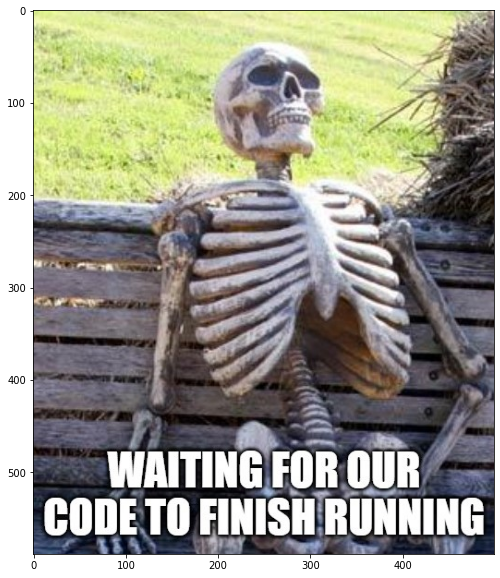

In [11]:
import imageio
meme = imageio.imread('meme.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(meme)